In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, f1_score, make_scorer
from sklearn.model_selection import cross_validate # ,KFold, cross_val_predict


In [2]:
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings("ignore")

##### Data load

In [3]:
train = pd.read_csv("data/customer_churn_dataset-training-master.csv")
test = pd.read_csv("data/customer_churn_dataset-testing-master.csv")

##### EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [6]:
# Check target variable counts in train
train["Churn"].value_counts(dropna=False)

Churn
1.0    249999
0.0    190833
NaN         1
Name: count, dtype: int64

In [7]:
# Check the nan record
train.loc[train["Churn"].isna()]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# delete the nan record
train = train.drop(199295).reset_index(drop=True)

In [9]:
# check if the record is deleted
train.loc[train["Churn"].isna()]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


In [10]:
# rename columns
train.columns = train.columns.str.replace(" ","_")
test.columns = test.columns.str.replace(" ","_")

In [11]:
train.describe()

,CustomerID,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [12]:
# Check target variable counts in test
test["Churn"].value_counts(dropna=False)

Churn
0    33881
1    30493
Name: count, dtype: int64

In [13]:
train.head()

,CustomerID,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [14]:
test.head()

,CustomerID,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [15]:
# convert float vars to int
for col in train.select_dtypes(include="float").columns:
    train[col] = train[col].astype("int64")

In [16]:
# check if all columns are converted
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   CustomerID         440832 non-null  int64 
 1   Age                440832 non-null  int64 
 2   Gender             440832 non-null  object
 3   Tenure             440832 non-null  int64 
 4   Usage_Frequency    440832 non-null  int64 
 5   Support_Calls      440832 non-null  int64 
 6   Payment_Delay      440832 non-null  int64 
 7   Subscription_Type  440832 non-null  object
 8   Contract_Length    440832 non-null  object
 9   Total_Spend        440832 non-null  int64 
 10  Last_Interaction   440832 non-null  int64 
 11  Churn              440832 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 40.4+ MB


In [17]:
# Save int cols as a list - it's going to be used later in plots
int_cols = [col for col in train.select_dtypes(include="int").columns]
int_cols

['CustomerID',
 'Age',
 'Tenure',
 'Usage_Frequency',
 'Support_Calls',
 'Payment_Delay',
 'Total_Spend',
 'Last_Interaction',
 'Churn']

In [18]:
# Throw out CustomerID
int_cols = int_cols[1:]
int_cols

['Age',
 'Tenure',
 'Usage_Frequency',
 'Support_Calls',
 'Payment_Delay',
 'Total_Spend',
 'Last_Interaction',
 'Churn']

##### Plots for train dataset

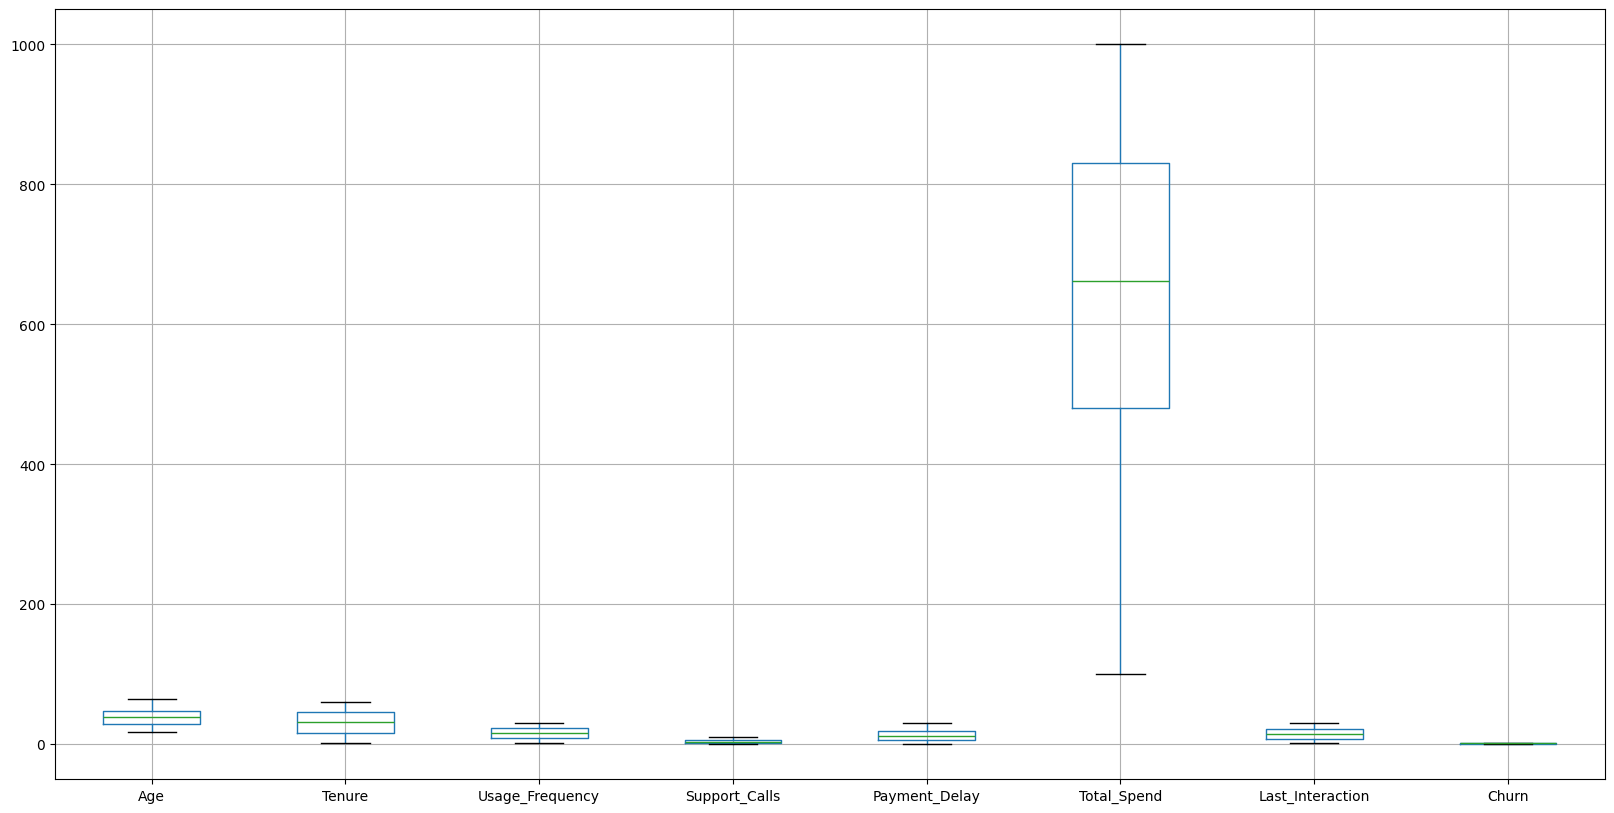

In [19]:
# boxplots for train
train[int_cols].boxplot(column=list(int_cols),figsize=(20,10))
plt.show()

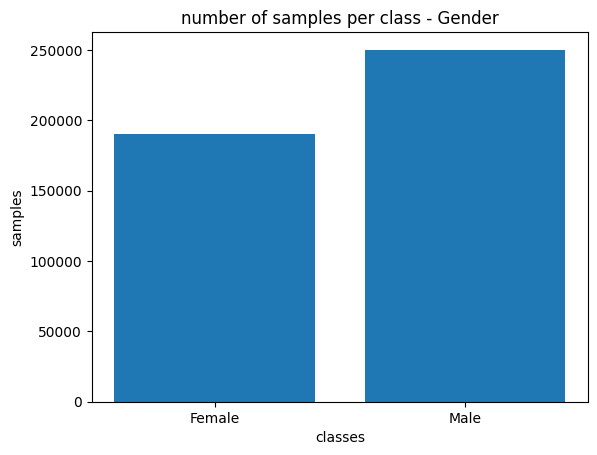

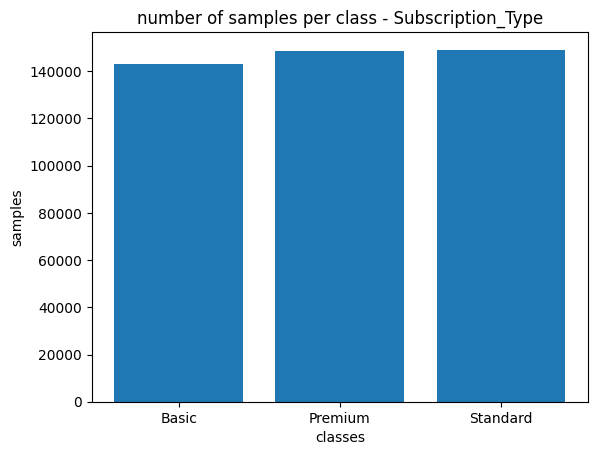

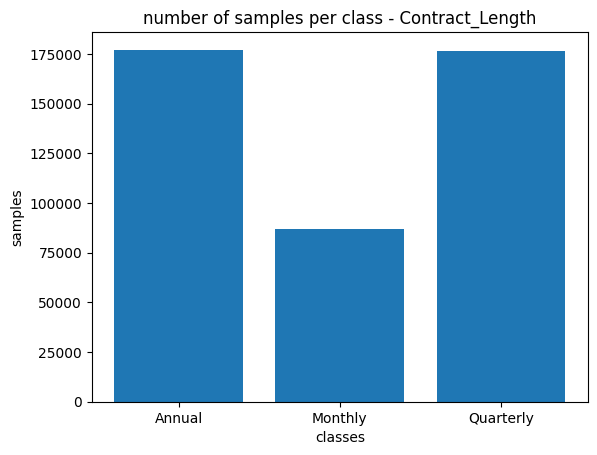

In [20]:
# counts for categorical columns (train)
for col in train.select_dtypes(include="object").columns:
    classVals, classCnts = np.unique(train[col], return_counts=True)
    fig = plt.Figure(figsize=(15,15))
    plt.bar(classVals, classCnts)
    plt.xlabel("classes")
    plt.ylabel("samples")
    plt.title(f"number of samples per class - {col}")
    plt.show()

##### Plots for test dataset

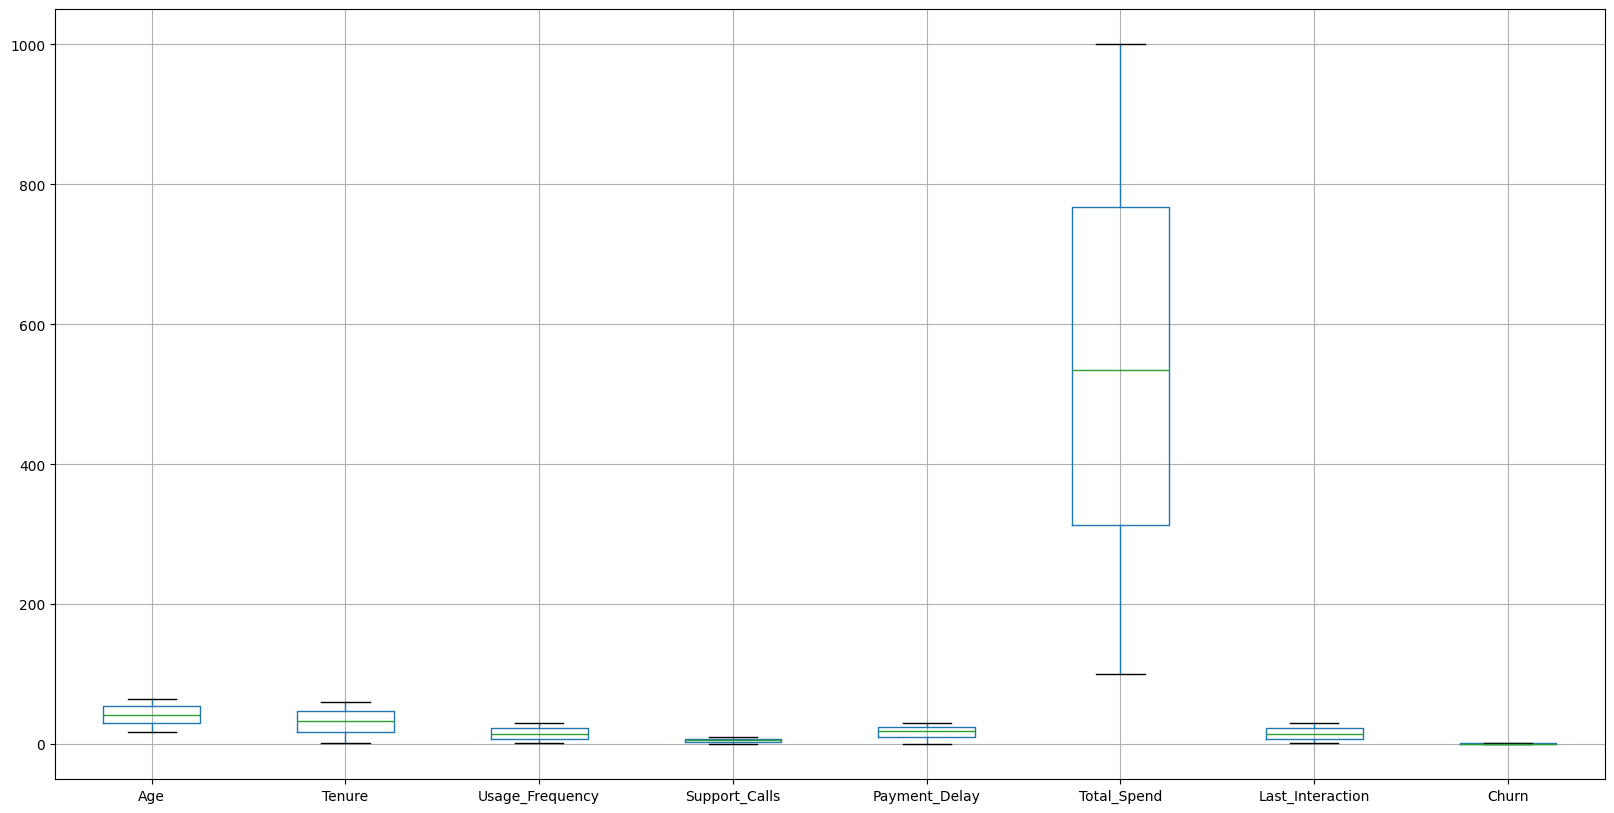

In [21]:
# boxplots for test
test[int_cols].boxplot(column=list(int_cols),figsize=(20,10))
plt.show()

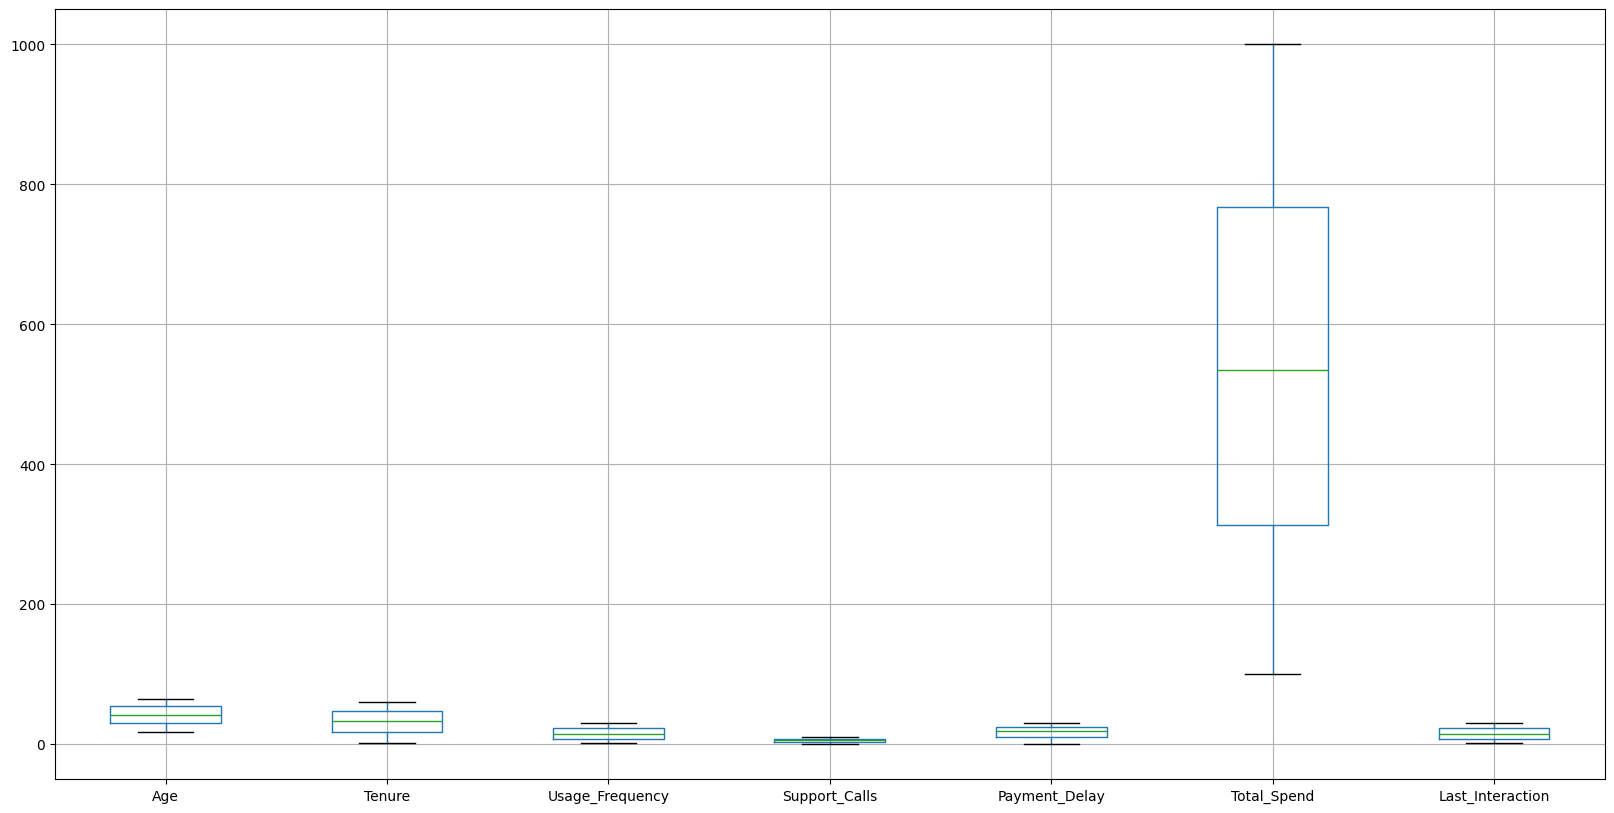

In [22]:
# boxplots for all int columns except the first and the last one (test)
test[int_cols[:-1]].boxplot(column=list(int_cols[:-1]),figsize=(20,10))
plt.show()

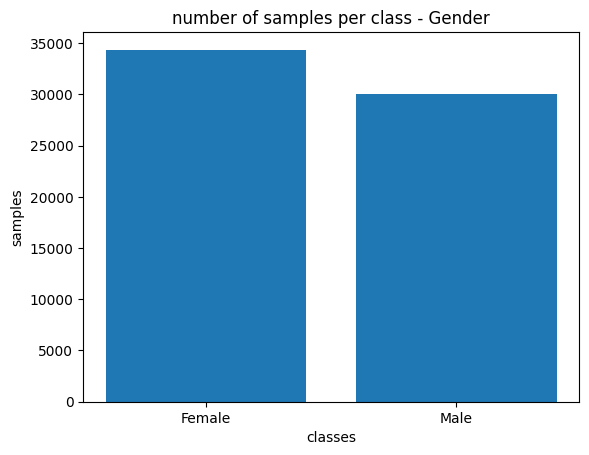

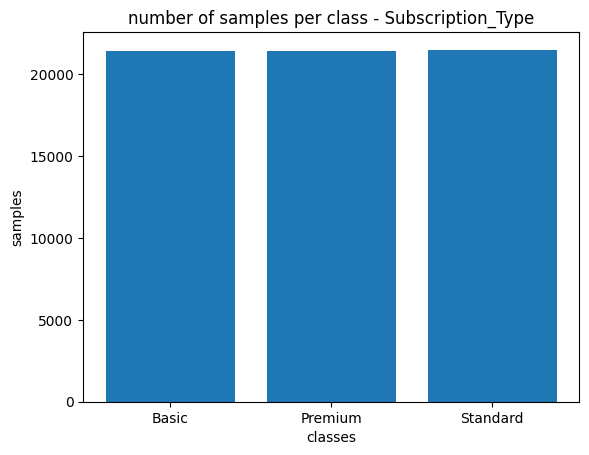

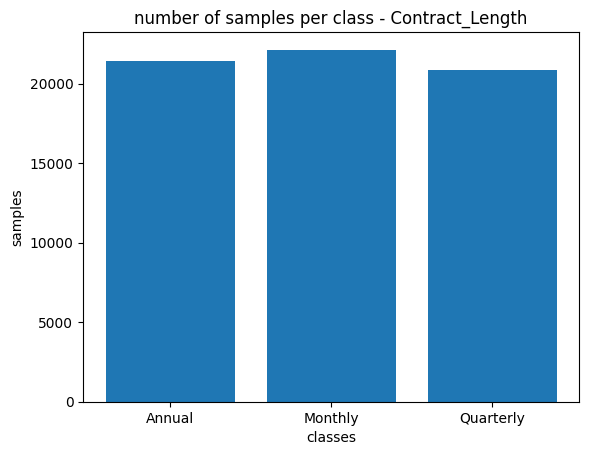

In [23]:
# counts for categorical columns (test)
for col in test.select_dtypes(include="object").columns:
    classVals, classCnts = np.unique(test[col], return_counts=True)
    fig = plt.Figure(figsize=(15,15))
    plt.bar(classVals, classCnts)
    plt.xlabel("classes")
    plt.ylabel("samples")
    plt.title(f"number of samples per class - {col}")
    plt.show()

##### Plots for combined train and test

In [24]:
# combine train and test
train["group"] = "train"
test["group"] = "test"
df = pd.concat([train, test])
train = train.drop("group", axis=1)
test = test.drop("group", axis=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505206 entries, 0 to 64373
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   CustomerID         505206 non-null  int64 
 1   Age                505206 non-null  int64 
 2   Gender             505206 non-null  object
 3   Tenure             505206 non-null  int64 
 4   Usage_Frequency    505206 non-null  int64 
 5   Support_Calls      505206 non-null  int64 
 6   Payment_Delay      505206 non-null  int64 
 7   Subscription_Type  505206 non-null  object
 8   Contract_Length    505206 non-null  object
 9   Total_Spend        505206 non-null  int64 
 10  Last_Interaction   505206 non-null  int64 
 11  Churn              505206 non-null  int64 
 12  group              505206 non-null  object
dtypes: int64(9), object(4)
memory usage: 54.0+ MB


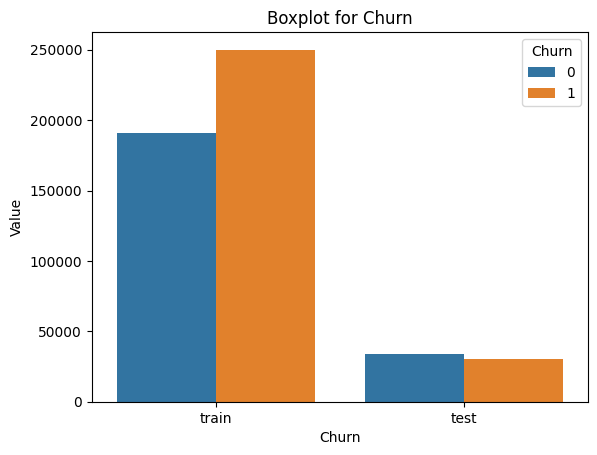

In [26]:
# Churn distribution
sns.countplot(x="group", hue="Churn", data=df)
plt.title("Boxplot for Churn")
plt.xlabel("Churn")
plt.ylabel("Value")
plt.show()

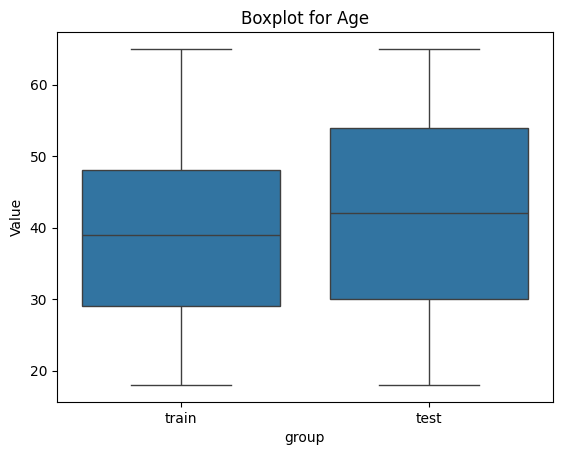

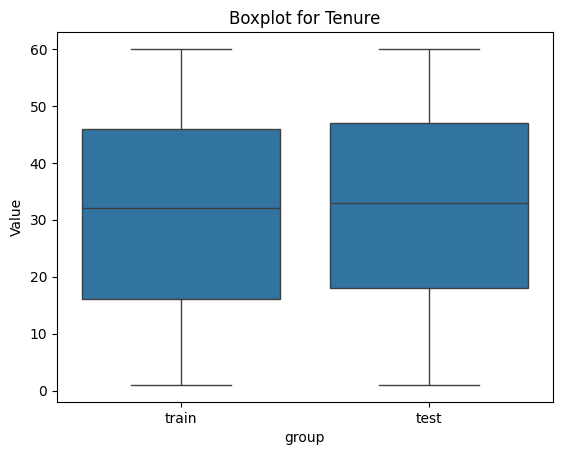

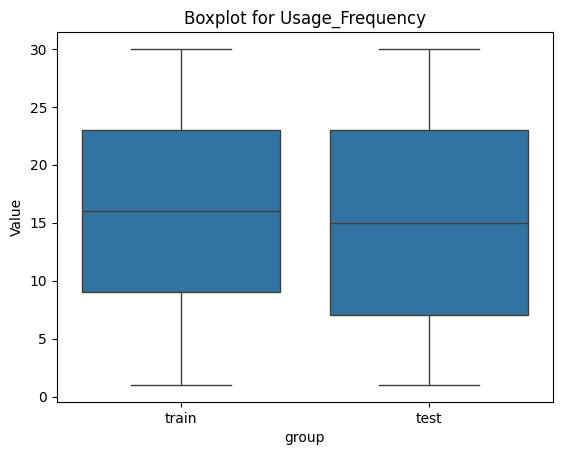

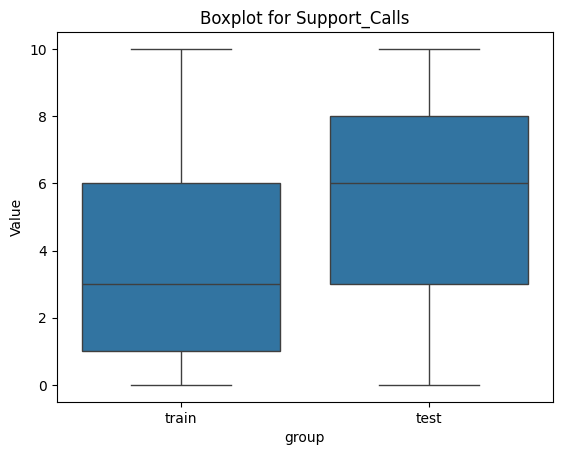

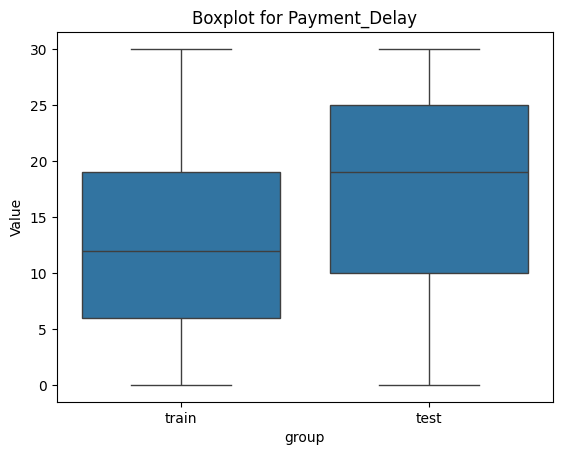

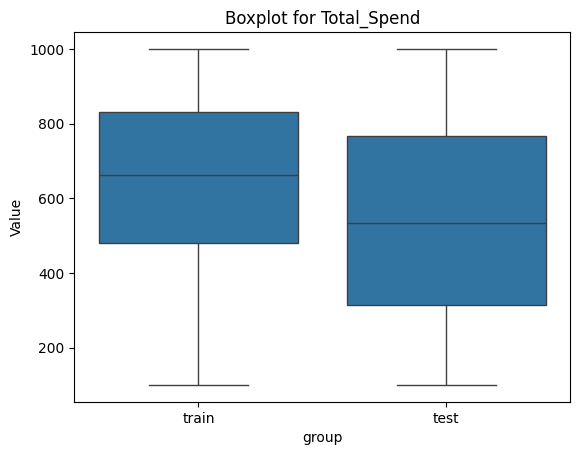

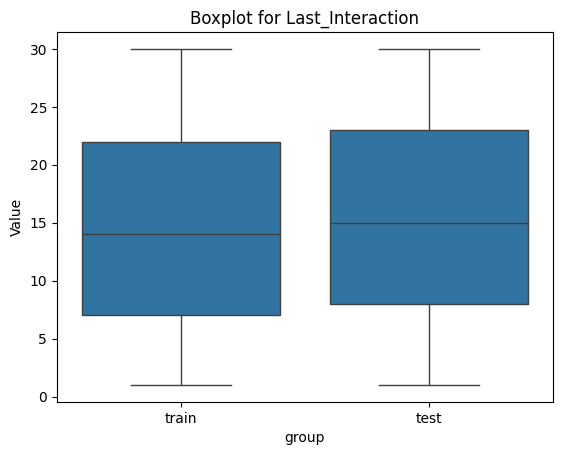

In [27]:
# Boxplots grouped by variable "group" for int cols except Churn and CustomerID
for col in int_cols[:-1]:
    sns.boxplot(x="group", y=col, data=df)

    # Tytuł i etykiety osi
    plt.title(f"Boxplot for {col}")
    plt.xlabel("group")
    plt.ylabel("Value")

    # Wyświetlenie wykresu
    plt.show()

In [28]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn,group
0,2,30,Female,39,14,5,18,Standard,Annual,932,17,1,train
1,3,65,Female,49,1,10,8,Basic,Monthly,557,6,1,train
2,4,55,Female,14,4,6,18,Basic,Quarterly,185,3,1,train
3,5,58,Male,38,21,7,7,Standard,Monthly,396,29,1,train
4,6,23,Male,32,20,5,8,Basic,Monthly,617,20,1,train


We can see that there are some values that exist in test dataset and don't exist in train dataset. Payment Delay and Total Spend have significantly varied distribution. Support Calls' scope is thin (min = 1, max = 8), so the plots seem to be quite various at first glance, but min and max values are not so different. However median in test dataset is twice as big as in train dataset.

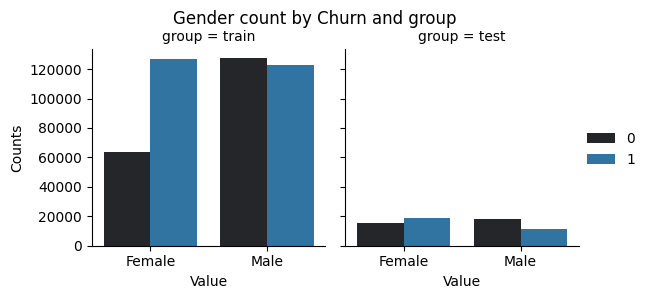

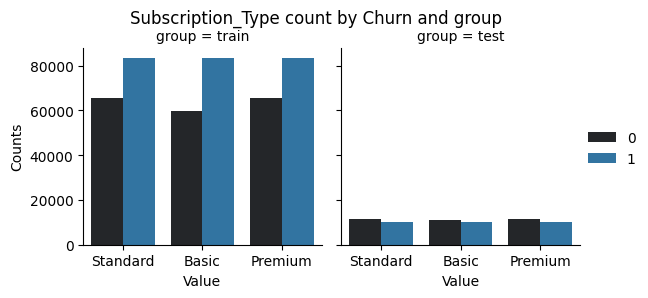

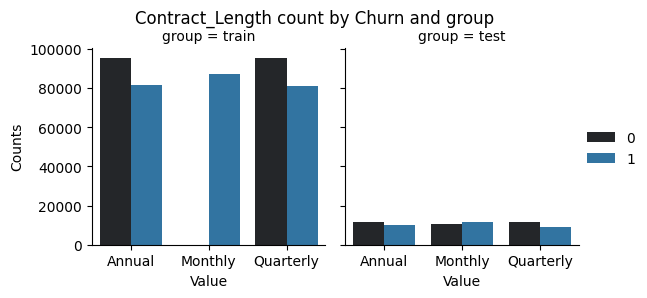

In [29]:
# counts for categorical columns except "group" (train vs test)
for col in df.select_dtypes(include="object").columns[:-1]:
    # sns.countplot(x="group", col="Churn", hue=col, data=df)
    # plt.title(f"Boxplot for {col}")
    # plt.xlabel("group")
    # plt.ylabel("Value")
    # plt.show()
    g = sns.FacetGrid(df, col="group", sharex=True, sharey=True)
    g.map_dataframe(sns.countplot, x=col, hue="Churn")
    g.add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f'{col} count by Churn and group')
    g.set_axis_labels('Value', 'Counts')
    plt.show()


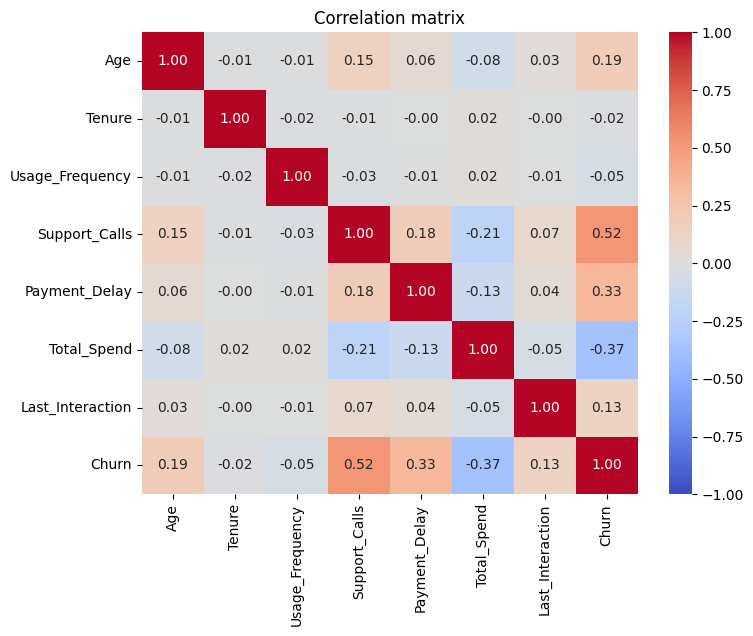

In [30]:
# Correlation matrix (withoud CustomerID) (combined train and test)
corr_matrix = df[int_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

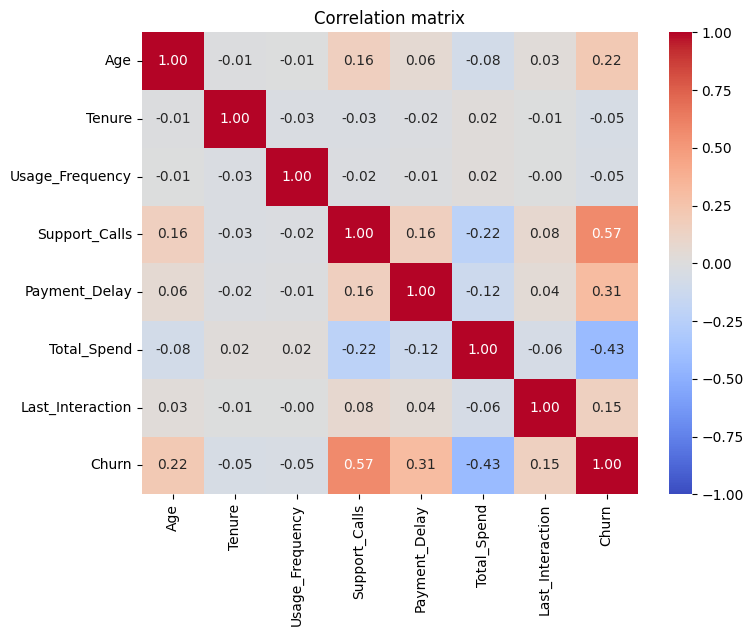

In [31]:
# Correlation matrix (withoud CustomerID) (train only)
corr_matrix = train[int_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

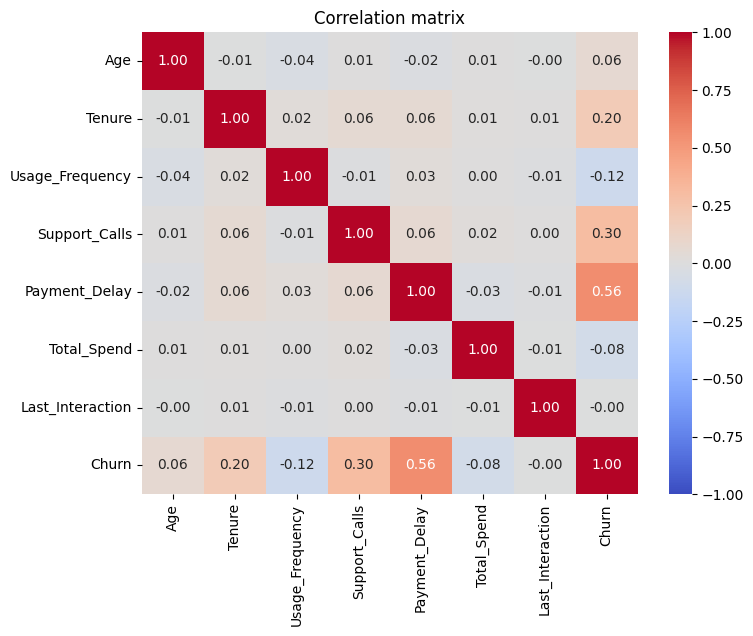

In [32]:
# Correlation matrix (withoud CustomerID) (test only)
corr_matrix = test[int_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

##### Plots grouped by train/test and churn 

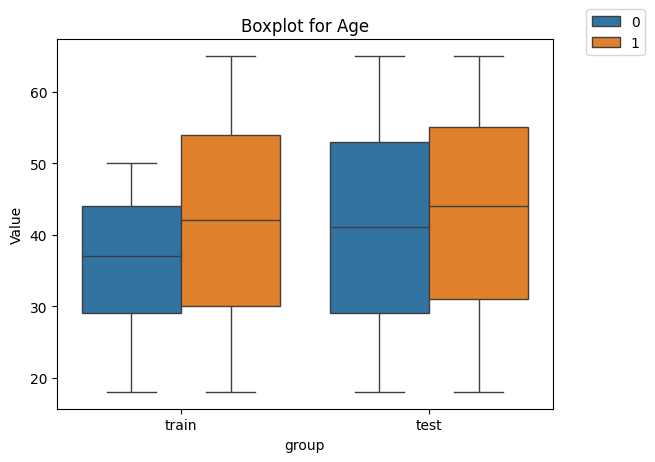

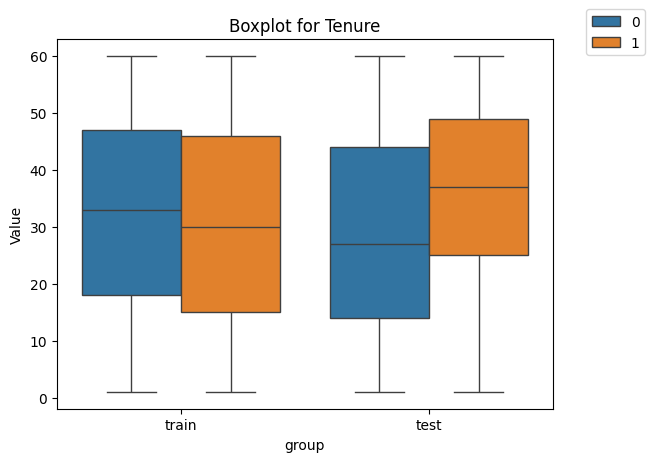

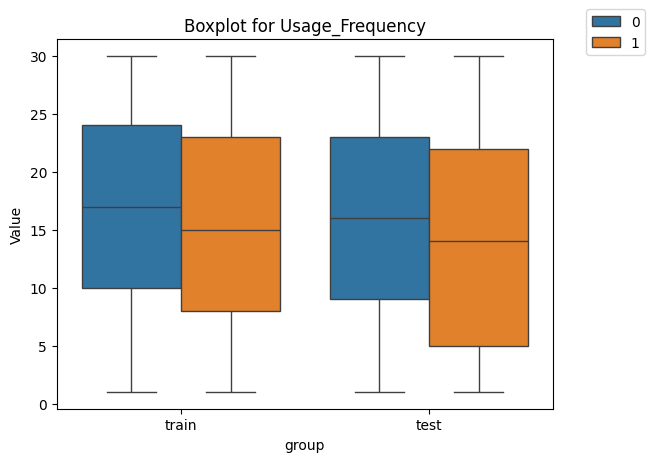

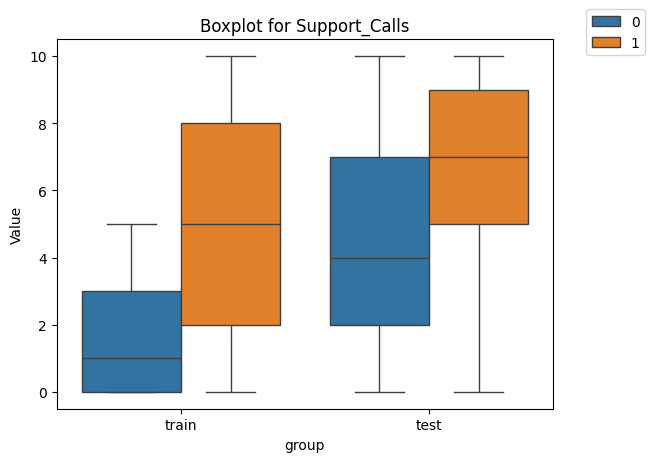

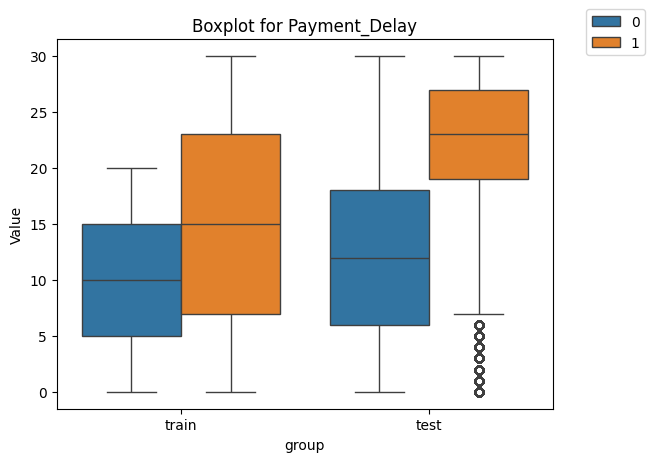

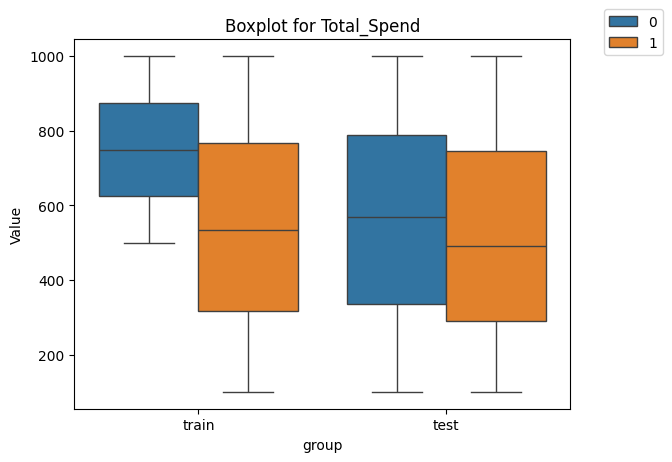

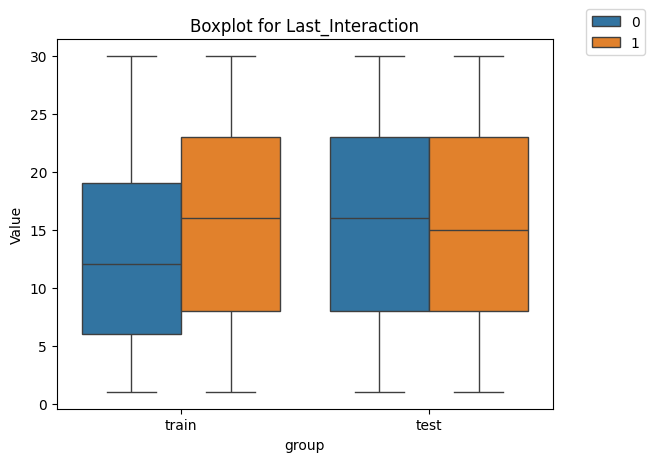

In [33]:
# Boxplots grouped by variables "group" and "Churn" for int cols except Churn and CustomerID
for col in int_cols[:-1]:
    sns.boxplot(x="group", y=col, hue="Churn", data=df)
    plt.title(f"Boxplot for {col}")
    plt.xlabel("group")
    plt.ylabel("Value")
    plt.legend(loc="upper right", bbox_to_anchor=(1.2,1.1))
    plt.show()

Let's focus on Support Calls. In training set for churn = 1 the number of Support calls between the Q1 and the Q2 (median) ranges from 2 to 5, meanwhile in the test set, the number 5 only marks the beginning of Q1. Support Calls alone won't be a good variable because of its distribution. Moreover, this suggests that predicting churn = 0 may be problematic in test set. \
The distributions of Payment Delay and Total Spend also suggest that the split was not random.

##### Histograms

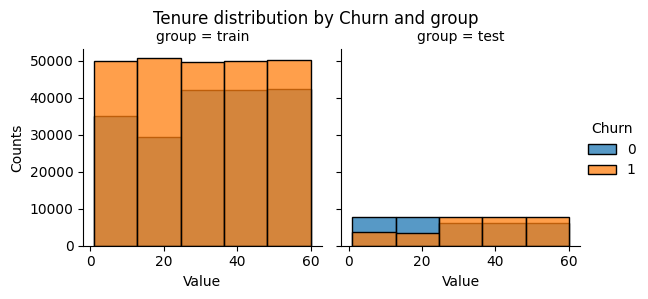

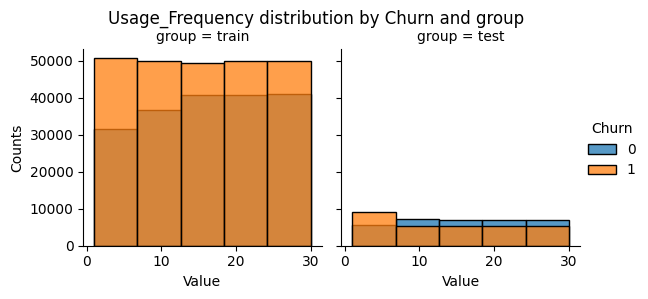

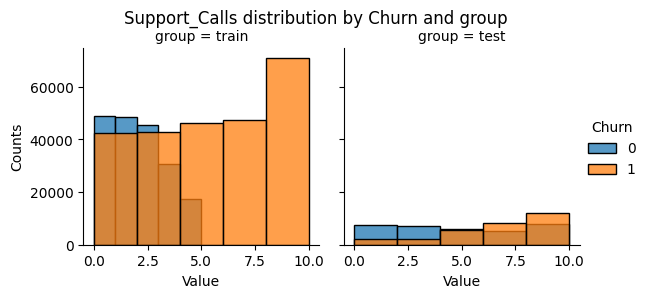

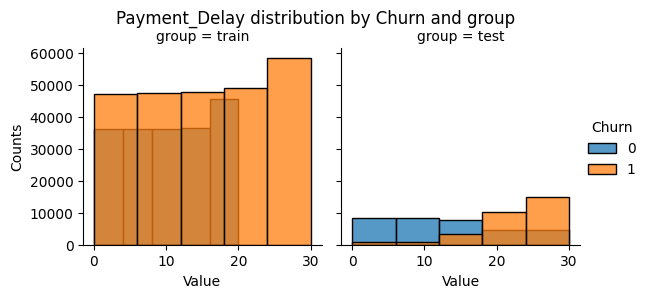

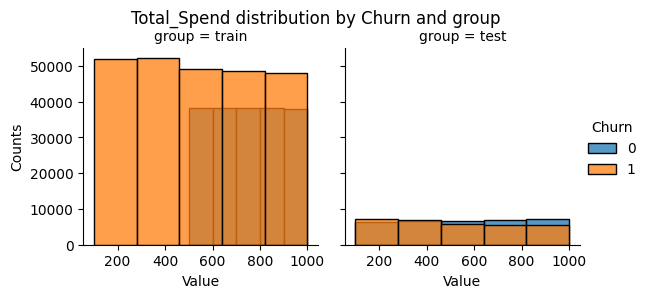

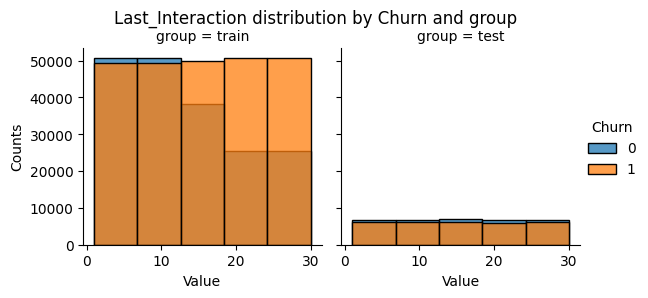

In [34]:
# Histograms - grouped by variables "group" and "Churn" for int cols except Churn and CustomerID
for col in int_cols[1:-1]:
    g = sns.FacetGrid(df, col="group", hue="Churn", sharex=True, sharey=True)
    g.map_dataframe(sns.histplot, bins=5, x=col, multiple='stack',)
    g.add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f'{col} distribution by Churn and group')
    g.set_axis_labels('Value', 'Counts')
    plt.show()



##### One hot encoder

In [35]:
cols_to_encode = [col for col in train.select_dtypes(include="object").columns]
# encoder = OneHotEncoder(sparse_output=False)
# encoded_data = encoder.fit_transform(train[cols_to_encode])
# encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cols_to_encode))
# train = pd.concat([train, encoded_data], axis=1)

train = pd.get_dummies(train, columns=cols_to_encode)
test = pd.get_dummies(test, columns=cols_to_encode)

In [36]:
# check the change
train.head()

,CustomerID,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Churn,Gender_Female,Gender_Male,Subscription_Type_Basic,Subscription_Type_Premium,Subscription_Type_Standard,Contract_Length_Annual,Contract_Length_Monthly,Contract_Length_Quarterly
0,2,30,39,14,5,18,932,17,1,True,False,False,False,True,True,False,False
1,3,65,49,1,10,8,557,6,1,True,False,True,False,False,False,True,False
2,4,55,14,4,6,18,185,3,1,True,False,True,False,False,False,False,True
3,5,58,38,21,7,7,396,29,1,False,True,False,False,True,False,True,False
4,6,23,32,20,5,8,617,20,1,False,True,True,False,False,False,True,False


In [37]:
# check info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   CustomerID                  440832 non-null  int64
 1   Age                         440832 non-null  int64
 2   Tenure                      440832 non-null  int64
 3   Usage_Frequency             440832 non-null  int64
 4   Support_Calls               440832 non-null  int64
 5   Payment_Delay               440832 non-null  int64
 6   Total_Spend                 440832 non-null  int64
 7   Last_Interaction            440832 non-null  int64
 8   Churn                       440832 non-null  int64
 9   Gender_Female               440832 non-null  bool 
 10  Gender_Male                 440832 non-null  bool 
 11  Subscription_Type_Basic     440832 non-null  bool 
 12  Subscription_Type_Premium   440832 non-null  bool 
 13  Subscription_Type_Standard  440832 non-null 

In [38]:
# creating a list of tuples consisting of new encoded variable names and pre-encoded variable names
encoded_cols = []
for col in cols_to_encode:
    for new_col in train.columns:
        if col in new_col:
            encoded_cols.append((new_col,col))

# creating a list of lineary independent variables
i=0
n=len(encoded_cols)-1
lineary_independent_encoded_cols =[]
while i <= n-1:
    elem1 = encoded_cols[i]
    elem2 = encoded_cols[i+1]
    if i == 0:
        lineary_independent_encoded_cols.append(elem1[0])
    else:
        if elem1[1] != elem2[1]:
            pass
        else:
            lineary_independent_encoded_cols.append(elem1[0])
    i+=1


lineary_independent_encoded_cols

['Gender_Female',
 'Subscription_Type_Basic',
 'Subscription_Type_Premium',
 'Contract_Length_Annual',
 'Contract_Length_Monthly']

In [39]:
# Replace Contract_Length_Monthly by Contract_Length_Quarterly due to its distribution in training set
lineary_independent_encoded_cols[-1] = "Contract_Length_Quarterly"
lineary_independent_encoded_cols

['Gender_Female',
 'Subscription_Type_Basic',
 'Subscription_Type_Premium',
 'Contract_Length_Annual',
 'Contract_Length_Quarterly']

##### Standarization/Normalization

In [40]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[int_cols[:-1]])
test_scaled = scaler.transform(test[int_cols[:-1]])

In [41]:
train.head()

,CustomerID,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Churn,Gender_Female,Gender_Male,Subscription_Type_Basic,Subscription_Type_Premium,Subscription_Type_Standard,Contract_Length_Annual,Contract_Length_Monthly,Contract_Length_Quarterly
0,2,30,39,14,5,18,932,17,1,True,False,False,False,True,True,False,False
1,3,65,49,1,10,8,557,6,1,True,False,True,False,False,False,True,False
2,4,55,14,4,6,18,185,3,1,True,False,True,False,False,False,False,True
3,5,58,38,21,7,7,396,29,1,False,True,False,False,True,False,True,False
4,6,23,32,20,5,8,617,20,1,False,True,True,False,False,False,True,False


In [42]:
train_scaled

array([[-0.7533263 ,  0.44875958, -0.21051068, ...,  0.60962048,
         1.24897052,  0.29305188],
       [ 2.05964592,  1.02827797, -1.7245625 , ..., -0.60131868,
        -0.30884022, -0.98658361],
       [ 1.25593957, -1.00003639, -1.37516593, ...,  0.60962048,
        -1.85418847, -1.33557511],
       ...,
       [-1.07480884,  0.21695223,  1.30354113, ..., -0.96460043,
         1.4359078 , -0.63759211],
       [-0.91406757,  1.37598901, -0.21051068, ..., -1.57007002,
        -0.12190293, -1.45190561],
       [-0.67295566,  0.97032613,  0.48828246, ...,  0.12524482,
        -0.2672986 ,  0.75837388]])

In [43]:
df_train_scaled = pd.DataFrame(train_scaled, columns=[col + str("_scaled") for col in int_cols[:-1]])
df_test_scaled = pd.DataFrame(test_scaled, columns=[col + str("_scaled") for col in int_cols[:-1]])

In [44]:
df_train_scaled.head()

,Age_scaled,Tenure_scaled,Usage_Frequency_scaled,Support_Calls_scaled,Payment_Delay_scaled,Total_Spend_scaled,Last_Interaction_scaled
0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.248971,0.293052
1,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.308840,-0.986584
2,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854188,-1.335575
3,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.977660,1.689018
4,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.059591,0.642043


In [45]:
train = pd.concat([train,df_train_scaled], axis=1)
test = pd.concat([test,df_test_scaled], axis=1)

In [46]:
train.head()

,CustomerID,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Churn,Gender_Female,Gender_Male,Subscription_Type_Basic,Subscription_Type_Premium,Subscription_Type_Standard,Contract_Length_Annual,Contract_Length_Monthly,Contract_Length_Quarterly,Age_scaled,Tenure_scaled,Usage_Frequency_scaled,Support_Calls_scaled,Payment_Delay_scaled,Total_Spend_scaled,Last_Interaction_scaled
0,2,30,39,14,5,18,932,17,1,True,False,False,False,True,True,False,False,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.248971,0.293052
1,3,65,49,1,10,8,557,6,1,True,False,True,False,False,False,True,False,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.308840,-0.986584
2,4,55,14,4,6,18,185,3,1,True,False,True,False,False,False,False,True,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854188,-1.335575
3,5,58,38,21,7,7,396,29,1,False,True,False,False,True,False,True,False,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.977660,1.689018
4,6,23,32,20,5,8,617,20,1,False,True,True,False,False,False,True,False,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.059591,0.642043


In [47]:
float_scaled_cols = df_train_scaled.columns.tolist()

Available columns to model: \
float_scaled_cols - standard scaled variables \
lineary_independent_encoded_cols - encoded variables and lineary independent 
***
encoded_cols - encoded variables, but not lineary independent \
cols_to_encode - original categorical columns that were encoded 

In [48]:
float_scaled_cols

['Age_scaled',
 'Tenure_scaled',
 'Usage_Frequency_scaled',
 'Support_Calls_scaled',
 'Payment_Delay_scaled',
 'Total_Spend_scaled',
 'Last_Interaction_scaled']

In [49]:
lineary_independent_encoded_cols

['Gender_Female',
 'Subscription_Type_Basic',
 'Subscription_Type_Premium',
 'Contract_Length_Annual',
 'Contract_Length_Quarterly']

In [50]:
# dfs to model on
X_train = train[float_scaled_cols+lineary_independent_encoded_cols]
y_train = train["Churn"]

X_test = test[float_scaled_cols+lineary_independent_encoded_cols]
y_test = test["Churn"]

##### A little bit more of EDA

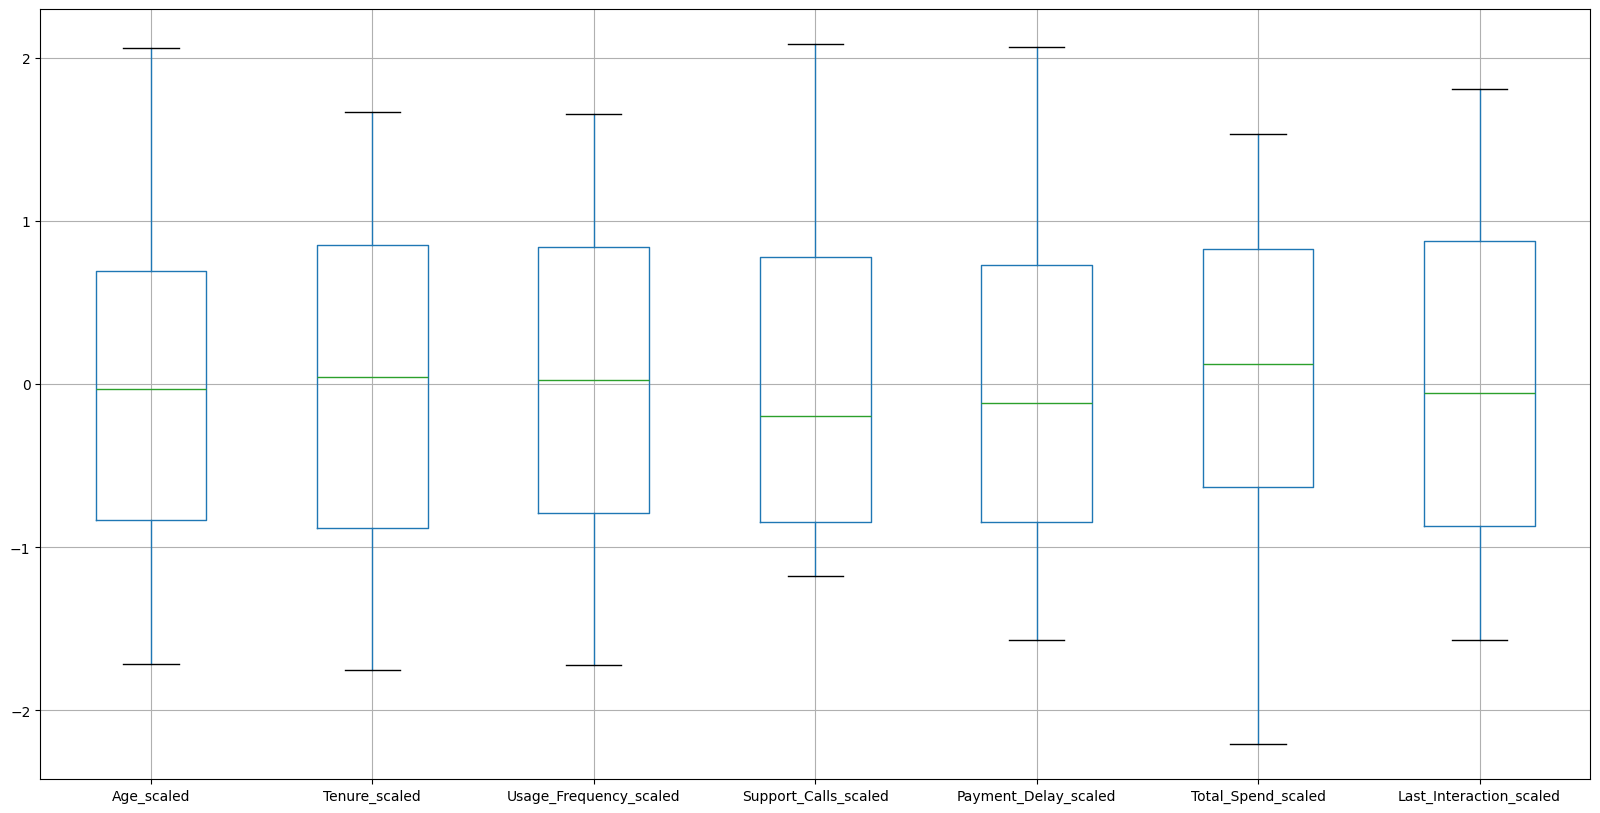

In [51]:
X_train[float_scaled_cols].boxplot(column=list(float_scaled_cols),figsize=(20,10))
plt.show()

In [52]:
X_train.describe()

,Age_scaled,Tenure_scaled,Usage_Frequency_scaled,Support_Calls_scaled,Payment_Delay_scaled,Total_Spend_scaled,Last_Interaction_scaled
count,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05
mean,7.994637e-17,1.779452e-17,-2.785228e-17,4.332578e-17,-3.094698e-18,-1.083144e-16,1.191459e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.717774e+00,-1.753410e+00,-1.724562e+00,-1.174002e+00,-1.570070e+00,-2.207292e+00,-1.568236e+00
25%,-8.336969e-01,-8.841327e-01,-7.928383e-01,-8.482914e-01,-8.435065e-01,-6.287107e-01,-8.702531e-01
50%,-2.999058e-02,4.309671e-02,2.242036e-02,-1.968711e-01,-1.169430e-01,1.231926e-01,-5.593961e-02
75%,6.933451e-01,8.544225e-01,8.376790e-01,7.802593e-01,7.307144e-01,8.252460e-01,8.747044e-01
max,2.059646e+00,1.665748e+00,1.652938e+00,2.083100e+00,2.062747e+00,1.531454e+00,1.805348e+00


In [53]:
X_test.describe()

,Age_scaled,Tenure_scaled,Usage_Frequency_scaled,Support_Calls_scaled,Payment_Delay_scaled,Total_Spend_scaled,Last_Interaction_scaled
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,0.208789,0.042797,-0.084701,0.585058,0.504747,-0.375210,0.118422
std,1.119154,0.990874,1.026815,1.014263,1.071949,1.083716,1.004914
min,-1.717774,-1.753410,-1.724562,-1.174002,-1.570070,-2.207292,-1.568236
25%,-0.753326,-0.768229,-1.025769,-0.196871,-0.359131,-1.322456,-0.753923
50%,0.211121,0.101049,-0.094045,0.780259,0.730714,-0.404386,0.060391
75%,1.175569,0.912374,0.837679,1.431680,1.457278,0.567688,0.991035
max,2.059646,1.665748,1.652938,2.083100,2.062747,1.531454,1.805348


In [54]:
train.loc[train["Payment_Delay"]==25, "Churn"].value_counts()

Churn
1    8362
Name: count, dtype: int64

In [55]:
test.loc[test["Payment_Delay"]==25, "Churn"].value_counts()

Churn
1    2135
0     646
Name: count, dtype: int64

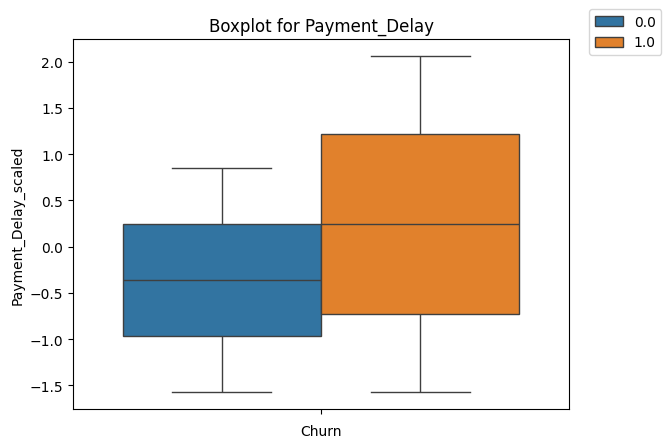

In [56]:
sns.boxplot(y="Payment_Delay_scaled", hue="Churn", data=pd.concat([X_train,y_train]))
plt.title(f"Boxplot for Payment_Delay")
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1.1))
plt.xlabel("Churn")
plt.show()

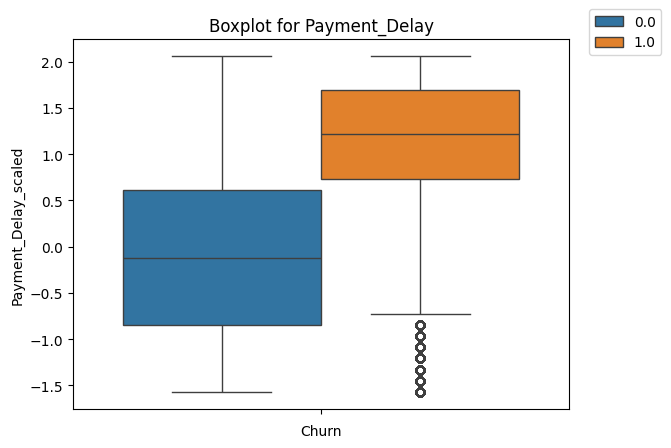

In [57]:
sns.boxplot(y="Payment_Delay_scaled", hue="Churn", data=pd.concat([X_test,y_test]))
plt.title(f"Boxplot for Payment_Delay")
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1.1))
plt.xlabel("Churn")
plt.show()

##### Metric

In this case we want to predict churn = 1 more accurately than churn = 0, because the loss of a client is a bigger revenue loss than offering some promotional actions to this client, if they wouldn't resign. \
However, as we could have seen on plots, churn = 0 will probably be more challenging than churn = 1. \
Generally recall would be a great metric in these types of problems, but in this particular case we should rely on f1-score.

##### Prediction and evaluation

In [58]:
def prediction_evaluation(
        X_train,
        X_test,
        y_train,
        y_test,
        model      
):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_score_train = accuracy_score(y_train, model.predict(X_train))
    acc_score = accuracy_score(y_test, y_pred)
    f1_score_train = f1_score(y_train, model.predict(X_train))

    print(f"Accuracy score train: {acc_score_train}\nAccuracy score test: {acc_score}")
    print(classification_report(y_test, y_pred))
    print(f"f1 score train: {f1_score_train}")

    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True: 0', 'True: 1'], columns=['Pred: 0', 'Pred: 1'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Actual values')
    plt.show()

    pred_train_proba = model.predict_proba(X_train)[:,1]
    pred_test_proba = model.predict_proba(X_test)[:,1]

    print(f"AUC train: {roc_auc_score(y_train,pred_train_proba)}")
    print(f"AUC test: {roc_auc_score(y_test,pred_test_proba)}")
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()

    return y_pred

#### Logistic regression

Accuracy score train: 0.8960805930603949
Accuracy score test: 0.5809954329387641
              precision    recall  f1-score   support

           0       0.95      0.22      0.35     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.52     64374
weighted avg       0.75      0.58      0.51     64374

f1 score train: 0.9048579338360668


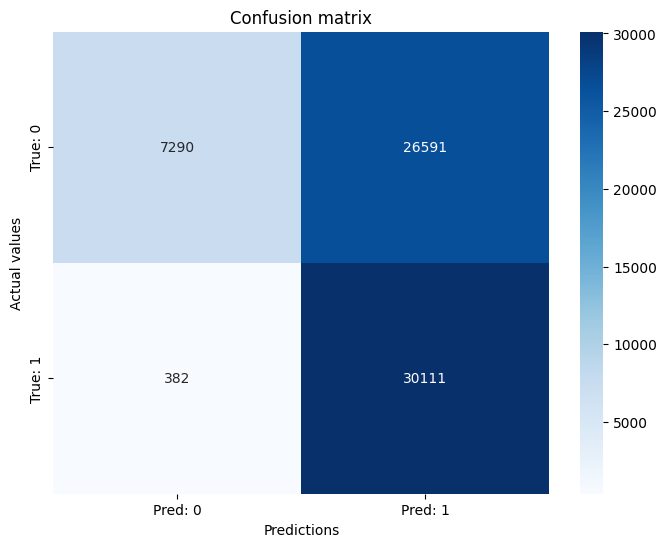

AUC train: 0.959467893920582
AUC test: 0.6969275726582331


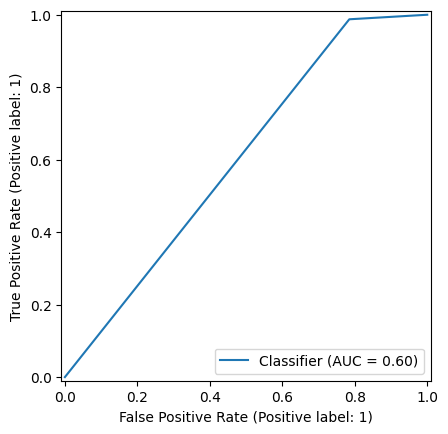

In [59]:
model = LogisticRegression(max_iter=100, random_state=42, solver="newton-cholesky", class_weight="balanced")
y_pred = prediction_evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    model
)
# 

As expected, train and test distributions are significantly various, hence test score is much lower than train score.

In [60]:
check_test = pd.concat([X_test, y_test, pd.DataFrame(y_pred, columns=["pred"])], axis=1)
check_test.loc[check_test["Churn"]!=check_test["pred"]].head()


,Age_scaled,Tenure_scaled,Usage_Frequency_scaled,Support_Calls_scaled,Payment_Delay_scaled,Total_Spend_scaled,Last_Interaction_scaled,Gender_Female,Subscription_Type_Basic,Subscription_Type_Premium,Contract_Length_Annual,Contract_Length_Quarterly,Churn,pred
1,0.130751,-0.188711,1.420007,1.105969,0.004151,-0.196678,0.642043,True,False,False,False,False,0,1
2,0.612974,-0.246662,-0.676373,-0.522581,1.941654,0.521992,0.758374,False,False,True,True,False,0,1
3,-0.351473,-1.289796,-0.443442,0.454549,0.488527,-1.658943,0.409382,False,False,True,False,True,0,1
4,1.095198,1.549845,0.954145,1.757390,-1.327882,-0.408540,0.409382,True,False,False,True,False,0,1
5,-0.753326,0.564663,-0.210511,2.083100,-0.359131,-0.545627,1.689018,False,False,True,False,False,0,1


Accuracy score train: 0.7200044461382114
Accuracy score test: 0.52803927051294
              precision    recall  f1-score   support

           0       0.59      0.33      0.42     33881
           1       0.50      0.75      0.60     30493

    accuracy                           0.53     64374
   macro avg       0.55      0.54      0.51     64374
weighted avg       0.55      0.53      0.51     64374

f1 score train: 0.742350202999593


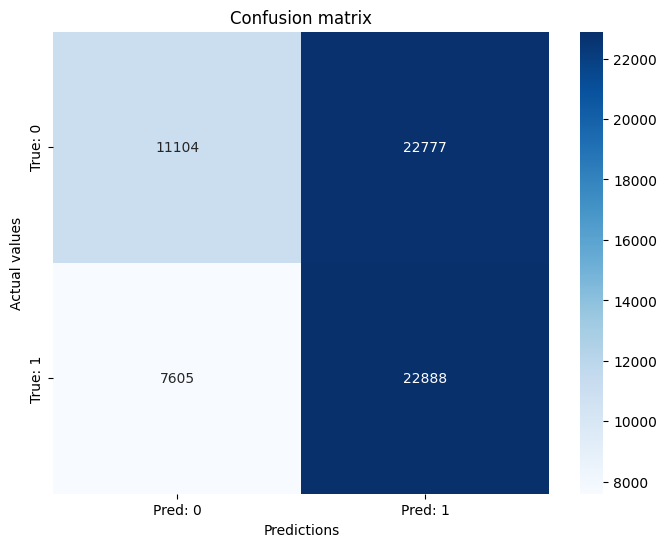

AUC train: 0.7994575576526933
AUC test: 0.5645566485657084


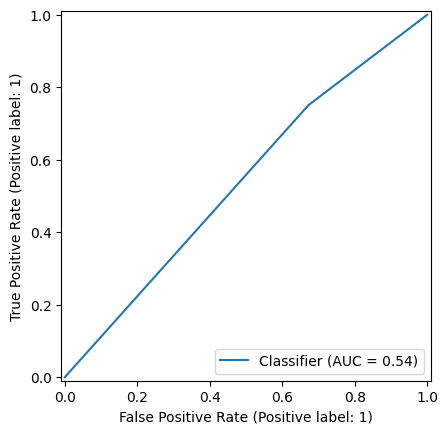

array([1, 1, 1, ..., 1, 1, 1])

In [61]:
model = LogisticRegression(max_iter=100)
cols_to_exclude = ["Payment_Delay_scaled", "Support_Calls_scaled", "Total_Spend_scaled"]
cols_selection = [col for col in X_train.columns if col not in cols_to_exclude]
prediction_evaluation(
    X_train[cols_selection],
    X_test[cols_selection],
    y_train,
    y_test,
    model
)

Accuracy score train: 0.6074082643728222
Accuracy score test: 0.5250877683536832
              precision    recall  f1-score   support

           0       0.60      0.28      0.39     33881
           1       0.50      0.79      0.61     30493

    accuracy                           0.53     64374
   macro avg       0.55      0.54      0.50     64374
weighted avg       0.55      0.53      0.49     64374

f1 score train: 0.682760782415987


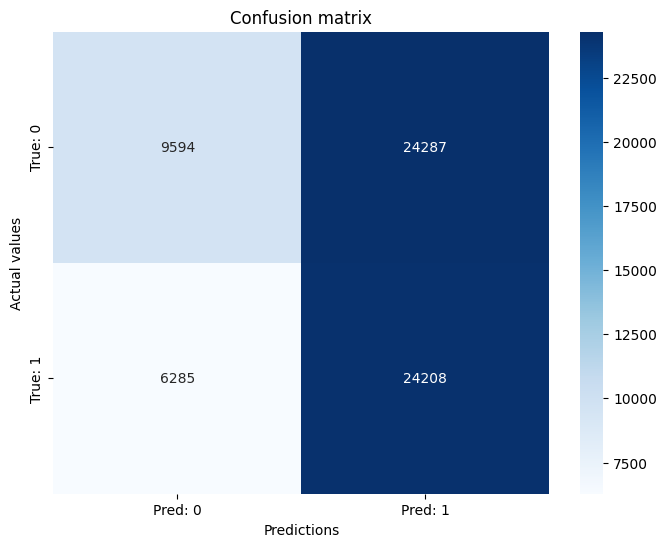

AUC train: 0.6616898610462812
AUC test: 0.5741190304814219


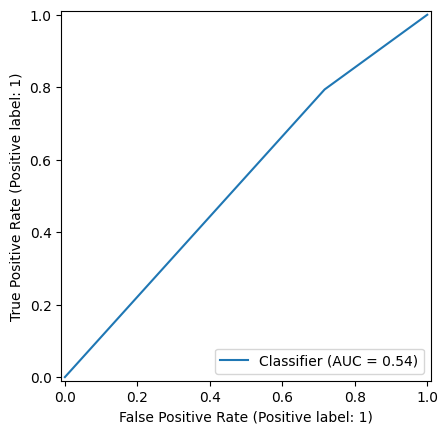

array([1, 1, 1, ..., 0, 1, 1])

In [62]:
model = LogisticRegression(max_iter=100)
# cols_to_exclude = ["Payment_Delay_scaled", "Support_Calls_scaled", "Total_Spend_scaled"]
# cols_selection = [col for col in X_train.columns if col not in cols_to_exclude]
cols_selection = ["Age_scaled", "Tenure_scaled", "Usage_Frequency_scaled", "Gender_Female"]
prediction_evaluation(
    X_train[cols_selection],
    X_test[cols_selection],
    y_train,
    y_test,
    model
)

##### XGBoost

Accuracy score train: 0.9999591681184669
Accuracy score test: 0.5034330630378724
              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374

f1 score train: 0.9999639985599424


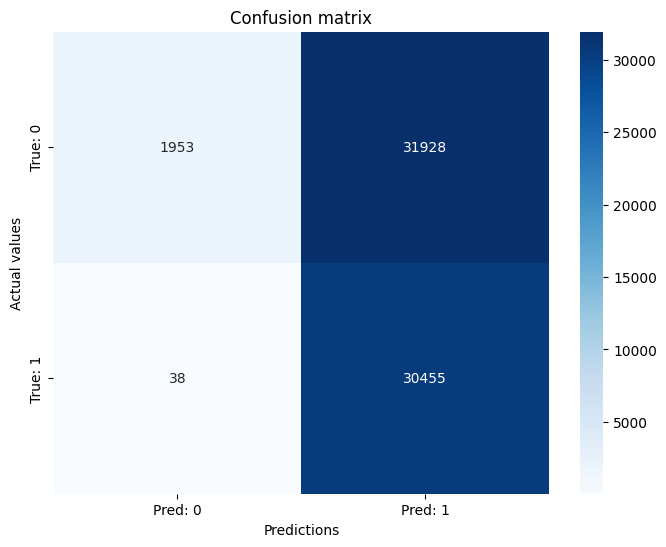

AUC train: 0.999999999895196
AUC test: 0.6521963893502603


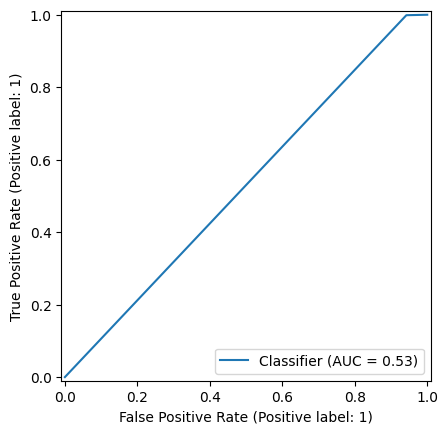

array([1, 1, 1, ..., 1, 1, 1])

In [63]:
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
prediction_evaluation(
    X_train,
    X_test,
    y_train,
    y_test,
    model
)

Accuracy score train: 0.8420169134727061
Accuracy score test: 0.523860564824308
              precision    recall  f1-score   support

           0       0.58      0.33      0.42     33881
           1       0.50      0.74      0.60     30493

    accuracy                           0.52     64374
   macro avg       0.54      0.53      0.51     64374
weighted avg       0.54      0.52      0.50     64374

f1 score train: 0.8386099562946381


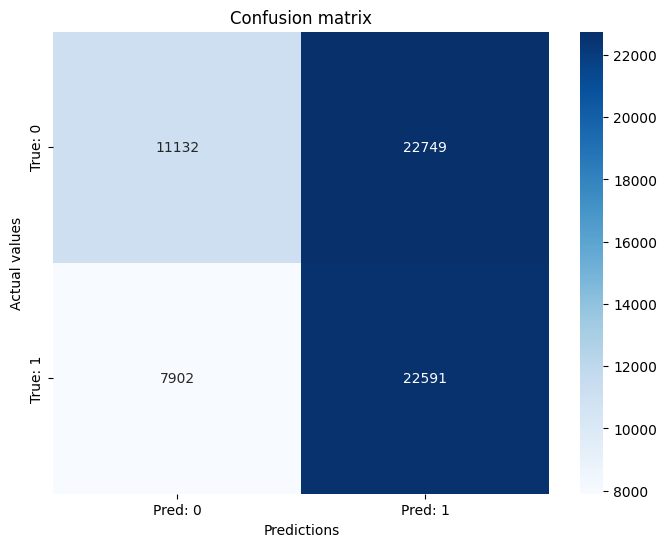

AUC train: 0.8941272999846995
AUC test: 0.5631175216374515


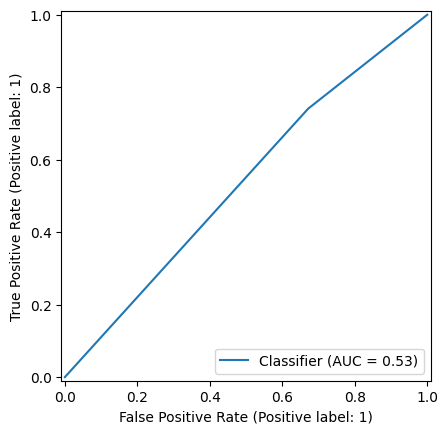

array([1, 1, 0, ..., 1, 1, 1])

In [64]:
model = xgb.XGBClassifier(objective='reg:logistic', random_state=42)
cols_to_exclude = ["Payment_Delay_scaled", "Support_Calls_scaled", "Total_Spend_scaled"]
cols_selection = [col for col in X_train.columns if col not in cols_to_exclude]
prediction_evaluation(
    X_train[cols_selection],
    X_test[cols_selection],
    y_train,
    y_test,
    model
)

##### Model Selection


Due to data distribution in train and test dataset all models give worse results for test records. To choose which one should be impelented, I would deepen the analysis, including revenue loss check and subscription conditions. We have information about Subscription Type and Contract Length, but can the client resign earlier or are they obliged to stay by subscription plan until it expires? What is the difference in revenue between a Premium customer and a Standard customer? After getting to know these information I would select a model that optimize the revenue.